In [1]:
#Package loading
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import preprocessing
from sklearn import decomposition
#from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-notebook')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
from sklearn.metrics import confusion_matrix

In [2]:
#CSV loading
#Data loading
dataset2 = pd.read_csv('Z1 - lastweek-P1MC5W1.csv', index_col = 'Unnamed: 0', parse_dates = ['LastInvoice', 'Timestamp'])
#print(dataset2.columns.values)
dataset2.shape


(17833, 112)

In [3]:
#CSV loading from api
#Data loading
#dataset2 = pd.read_csv('status.csv', index_col = 'Unnamed: 0', parse_dates = ['LastInvoice', 'Timestamp'])
#print(dataset2.columns.values)
#dataset2.shape


In [4]:
#Copy of the CSV file
dataset = dataset2
dataset.shape

(17833, 112)

In [5]:
#downsampling for test
dataset = dataset2.sample(n=1000)
dataset.shape

(1000, 112)

In [6]:
#Data split per RFM code
dataset[['Timestamp', 'RFMDC']].groupby('RFMDC').count().sort_values('Timestamp').head()

,Timestamp
RFMDC,
23321,1
22232,1
42423,1
22222,1
32243,1


In [7]:
#datastamping addition on dataset
dataset['Weekday'] = dataset['Timestamp'].apply(lambda x: x.weekday())

dataset[['Weekday', 'Timestamp']].head()

,Weekday,Timestamp
2723,2,2011-12-07
704,2,2011-12-07
891,0,2011-12-05
1537,4,2011-12-09
556,1,2011-12-06


In [8]:
#data split per criteria
criterias = ['M', 'F', 'R', 'D', 'C']
testingsize = 0.28
testlist = []
for criteria in criterias:
    df = dataset[[criteria,'CustomerID']].groupby('CustomerID', as_index = False).nth(-1)
    df = df[[criteria,'CustomerID']].groupby(criteria)
    tempdict = df['CustomerID'].apply(set).to_dict()
    print(criteria)
    for keys, values in tempdict.items():
        rows = random.sample(list(values), int(testingsize * len(values)/len(criterias)))
        print(int(testingsize * len(values)/len(criterias)),len([x for x in rows if x not in testlist]) , len(values))
        testlist.extend([x for x in rows if x not in testlist])
len(testlist)

M
12 12 215
12 12 231
11 11 213
11 11 201
F
13 13 242
14 14 253
1 1 23
19 16 342
R
12 10 227
12 9 221
11 10 203
11 10 209
D
12 10 224
11 9 211
11 10 214
11 8 211
C
42 38 752
4 2 80
1 1 28


207

In [9]:
#labels definition
target = ['R', 'F', 'M', 'D', 'C', 'RFMDC']
variables = [x for x in dataset.columns.values if x not in ['R', 'F', 'M', 'D', 'C', 'RFMDC', 'CustomerID','LastInvoice' ,'Timestamp']]

In [10]:
#testing and training set creation
mask = dataset['CustomerID'].isin([x for x in dataset['CustomerID'].unique() if x not in testlist])
trainingset = dataset.loc[mask]
trainingset.head()

mask = dataset['CustomerID'].isin(testlist)
testingset = dataset.loc[mask]
testingset.head()



,CustomerID,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,...,Weekday_6_Sunday_std,F,R,M,D,RatioCancel,C,RFMDC,Timestamp,Weekday
1537,15639.0,2011-07-28 14:30:00,133,425.32,425.32,425.320,425.32,0.000000,0.000000,0,...,0.000000,4,4,3,2,0.000000,1,44321,2011-12-09,4
2158,16764.0,2011-12-06 11:41:00,2,-14.45,351.59,152.775,2749.95,114.827915,7.388889,27,...,40.767063,1,1,1,4,-0.014909,1,11141,2011-12-09,4
1557,15689.0,2011-08-12 09:37:00,114,150.60,150.60,150.600,150.60,0.000000,241.000000,241,...,0.000000,4,4,4,3,0.000000,1,44431,2011-12-05,0
2447,17286.0,2011-11-18 12:47:00,20,151.37,151.37,151.370,151.37,0.000000,0.000000,0,...,0.000000,4,2,4,3,0.000000,1,24431,2011-12-09,4
2225,16914.0,2011-11-03 15:27:00,31,183.76,183.76,183.760,183.76,0.000000,0.000000,0,...,0.000000,4,3,4,3,0.000000,1,34431,2011-12-05,0


In [11]:
#Sets creation
Xtest = testingset[variables]
ytest = testingset[target]
Xtrain = trainingset[variables]
ytrain = trainingset[target]
Xtest.head()

,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,OrderSepStd,...,Weekday_3_Thursday_mean,Weekday_3_Thursday_std,Weekday_4_Friday_sum,Weekday_4_Friday_mean,Weekday_4_Friday_std,Weekday_6_Sunday_sum,Weekday_6_Sunday_mean,Weekday_6_Sunday_std,RatioCancel,Weekday
1537,133,425.32,425.32,425.320,425.32,0.000000,0.000000,0,0,0.000000,...,425.320000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,4
2158,2,-14.45,351.59,152.775,2749.95,114.827915,7.388889,27,0,7.701328,...,20.634444,65.303121,1132.21,62.900556,108.983665,172.96,9.608889,40.767063,-0.014909,4
1557,114,150.60,150.60,150.600,150.60,0.000000,241.000000,241,241,0.000000,...,0.000000,0.000000,150.60,150.600000,0.000000,0.00,0.000000,0.000000,0.000000,0
2447,20,151.37,151.37,151.370,151.37,0.000000,0.000000,0,0,0.000000,...,0.000000,0.000000,151.37,151.370000,0.000000,0.00,0.000000,0.000000,0.000000,4
2225,31,183.76,183.76,183.760,183.76,0.000000,0.000000,0,0,0.000000,...,183.760000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0


In [12]:
#Data standardisation
std_scale = preprocessing.StandardScaler().fit(Xtrain)
X_train_scaled = std_scale.transform(Xtrain)
X_test_scaled = std_scale.transform(Xtest)

In [13]:
#Gridsearch creation - XGBoostingClassifier

parameters = {'max_depth': [7,10], 'min_child_weight': [1,5], 'gamma': [i/10.0 for i in range(0,5)]}
scorer = make_scorer(f1_score, average = 'micro')
ind_params = {'learning_rate': 0.1, 'n_estimators': 10, 'objective': 'multi:softmax', 'tree_method':'hist'}
skf = StratifiedKFold(n_splits=3)
#xgbc = xgb.XGBClassifier(**ind_params)
xgbcclf = GridSearchCV(xgb.XGBClassifier(**ind_params), parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5)
xgbcclf.fit(X_train_scaled, ytrain['M'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] gamma=0.0, max_depth=7, min_child_weight=1 ......................
[CV] gamma=0.0, max_depth=7, min_child_weight=1 ......................
[CV] gamma=0.0, max_depth=7, min_child_weight=1 ......................
[CV]  gamma=0.0, max_depth=7, min_child_weight=1, score=0.9841897233201581, total=   0.3s
[CV]  gamma=0.0, max_depth=7, min_child_weight=1, score=0.992, total=   0.2s
[CV] gamma=0.0, max_depth=7, min_child_weight=5 ......................
[CV] gamma=0.0, max_depth=7, min_child_weight=5 ......................
[CV]  gamma=0.0, max_depth=7, min_child_weight=1, score=0.9920948616600791, total=   0.3s
[CV] gamma=0.0, max_depth=7, min_child_weight=5 ......................
[CV]  gamma=0.0, max_depth=7, min_child_weight=5, score=0.9723320158102767, total=   0.2s
[CV] gamma=0.0, max_depth=10, min_child_weight=1 .....................
[CV]  gamma=0.0, max_depth=7, min_child_weight=5, score=0.9841897233201581, total=   0.2s
[CV] 

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    0.8s


[CV]  gamma=0.1, max_depth=7, min_child_weight=1, score=0.992, total=   0.2s
[CV] gamma=0.1, max_depth=7, min_child_weight=5 ......................
[CV]  gamma=0.1, max_depth=7, min_child_weight=1, score=0.9920948616600791, total=   0.2s
[CV] gamma=0.1, max_depth=7, min_child_weight=5 ......................
[CV]  gamma=0.1, max_depth=7, min_child_weight=5, score=0.9723320158102767, total=   0.2s
[CV] gamma=0.1, max_depth=10, min_child_weight=1 .....................
[CV]  gamma=0.1, max_depth=7, min_child_weight=5, score=0.9841897233201581, total=   0.2s
[CV]  gamma=0.1, max_depth=7, min_child_weight=5, score=0.992, total=   0.2s
[CV] gamma=0.1, max_depth=10, min_child_weight=1 .....................
[CV] gamma=0.1, max_depth=10, min_child_weight=1 .....................
[CV]  gamma=0.1, max_depth=10, min_child_weight=1, score=0.9841897233201581, total=   0.2s
[CV]  gamma=0.1, max_depth=10, min_child_weight=1, score=0.992, total=   0.2s
[CV] gamma=0.1, max_depth=10, min_child_weight=5 ...

[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    4.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='hist'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_depth': [7, 10], 'min_child_weight': [1, 5], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=micro), verbose=5)

In [14]:
xgbcclf.score(X_test_scaled, ytest['M'])

1.0

In [15]:
xgbcclf.best_params_

{'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 1}

In [18]:
#Parameter to train for definition
parametertoclass = 'R'
scorer = make_scorer(f1_score, average = 'micro')
skf = StratifiedKFold(n_splits=3)
ind_params ={ 'n_estimators':30, 'learning_rate':0.1, 'nthread':3, 'objective': 'multi:softmax'}

In [19]:
#Gridsearch creation - XGBoostingClassifier - Step 1
step1 = {**ind_params}
parameters = {'max_depth': range(8,13,2), 'min_child_weight':range(1,6,2) }
xgbc1 = xgb.XGBClassifier(**step1)
xgbcclf1 = GridSearchCV(xgbc1, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
xgbcclf1.fit(X_train_scaled, ytrain[parametertoclass])
xgbcclf1.score(X_test_scaled, ytest[parametertoclass])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] ...... max_depth=8, min_child_weight=1, score=0.98, total=   0.5s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9880952380952381, total=   0.5s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9881889763779528, total=   0.6s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9920634920634921, total=   0.5s
[CV]  max_depth=8, min_child_weight=3, score=0.9921259842519685, total=   0.5s
[CV] ..... max_depth=8, min_child_weight=3, score=0.976, total=   0.5s
[CV] max_depth=8, min_child_weight=5 ...................

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.1s


[CV] .... max_depth=10, min_child_weight=3, score=0.976, total=   0.5s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9921259842519685, total=   0.5s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9920634920634921, total=   0.5s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9803149606299214, total=   0.5s
[CV] max_depth=12, min_child_weight=1 ................................
[CV] ..... max_depth=10, min_child_weight=5, score=0.96, total=   0.5s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9841269841269841, total=   0.5s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=12, min_child_weight=1, score=0.9881889763779528, total=   0.5s
[CV] max_depth=12, min_child_wei

[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:    4.7s finished


0.98770491803278693

In [20]:
#xgbcclf1.cv_results_
#xgbcclf1.grid_scores_
xgbcclf1.best_params_

{'max_depth': 8, 'min_child_weight': 3}

In [21]:
#Gridsearch creation - XGBoostingClassifier - Step 2
step2 = {**xgbcclf1.best_params_, **step1}
parameters = {'gamma':[i/10.0 for i in range(0,3)]}
xgbc2 = xgb.XGBClassifier(**step2)
xgbcclf2 = GridSearchCV(xgbc2, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
xgbcclf2.fit(X_train_scaled, ytrain[parametertoclass])
xgbcclf2.score(X_test_scaled, ytest[parametertoclass])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] ........................... gamma=0.0, score=0.976, total=   0.5s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9920634920634921, total=   0.6s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9921259842519685, total=   0.6s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.9921259842519685, total=   0.5s
[CV] gamma=0.2 .......................................................
[CV] ........................... gamma=0.1, score=0.976, total=   0.5s
[CV] gamma=0.2 .......................................................
[CV] .............

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:    1.1s remaining:    0.6s


[CV] .............. gamma=0.2, score=0.9921259842519685, total=   0.5s
[CV] ........................... gamma=0.2, score=0.976, total=   0.5s
[CV] .............. gamma=0.2, score=0.9920634920634921, total=   0.5s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    1.6s finished


0.98770491803278693

In [22]:
xgbcclf2.best_params_

{'gamma': 0.0}

In [23]:
#Gridsearch creation - XGBoostingClassifier - Step 3
step3 = {**xgbcclf2.best_params_, **step2}

parameters = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
xgbc3 = xgb.XGBClassifier(**step3)
xgbcclf3 = GridSearchCV(xgbc3, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
xgbcclf3.fit(X_train_scaled, ytrain[parametertoclass])
xgbcclf3.score(X_test_scaled, ytest[parametertoclass])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] . colsample_bytree=0.6, subsample=0.6, score=0.968, total=   0.4s
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.984251968503937, total=   0.4s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9920634920634921, total=   0.4s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9763779527559056, total=   0.4s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV] . colsample_bytree=0.6, subsample=0.7, score=0.976, total=   0.4s
[CV] colsample_bytree=0.6, subsample=0.8 ...........

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.9s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9803149606299214, total=   0.4s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] . colsample_bytree=0.7, subsample=0.6, score=0.972, total=   0.4s
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9920634920634921, total=   0.4s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9763779527559056, total=   0.5s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9920634920634921, total=   0.5s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV] . colsample_bytree=0.7, subsample=0.7, score=0.968, total=   0.5s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.9763779527559056, total=   0.4s
[CV] colsample_by

[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:    7.6s finished


0.98770491803278693

In [24]:
xgbcclf3.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.9}

In [25]:
#Gridsearch creation - XGBoostingClassifier - Step 4
step4 = {**xgbcclf3.best_params_, **step3}

parameters = {'learning_rate':[0.01, 0.05, 0.1]}
xgbc4 = xgb.XGBClassifier(**step4)
xgbcclf4 = GridSearchCV(xgbc4, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
xgbcclf4.fit(X_train_scaled, ytrain[parametertoclass])
xgbcclf4.score(X_test_scaled, ytest[parametertoclass])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] .................. learning_rate=0.01, score=0.968, total=   0.5s
[CV] ..... learning_rate=0.01, score=0.9763779527559056, total=   0.5s
[CV] learning_rate=0.05 ..............................................
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.9920634920634921, total=   0.5s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.05, score=0.9881889763779528, total=   0.5s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.05, score=0.9920634920634921, total=   0.5s
[CV] learning_rate=0.1 ...............................................
[CV] .............

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:    1.0s remaining:    0.5s


[CV] ...... learning_rate=0.1, score=0.9921259842519685, total=   0.5s
[CV] .................... learning_rate=0.1, score=0.98, total=   0.5s
[CV] ...... learning_rate=0.1, score=0.9920634920634921, total=   0.5s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    1.5s finished


0.98770491803278693

In [26]:
xgbcclf4.best_params_

{'learning_rate': 0.1}

In [27]:
#Step 5 final calculation
step5 = {**xgbcclf4.best_params_, **step4}
xgbc5 = xgb.XGBClassifier(**step5)
xgbc5.fit(X_train_scaled, ytrain[parametertoclass])
xgbc5.score(X_test_scaled, ytest[parametertoclass])

0.98770491803278693

In [112]:
#Training for all the parameters XgBoost
xgboostdict = {}
parameterlist = ['R', 'F', 'M', 'D', 'C']
scorer = make_scorer(f1_score, average = 'micro')
skf = StratifiedKFold(n_splits=3)
ind_params ={ 'n_estimators':30, 'learning_rate':0.1, 'nthread':3, 'objective': 'multi:softmax'}
featureimportancedictXGBoost = {}

for parametertoclass in parameterlist:
    #Gridsearch creation - XGBoostingClassifier - Step 1
    step1 = {**ind_params}
    parameters = {'max_depth': range(8,13,2), 'min_child_weight':range(1,6,2) }
    xgbc1 = xgb.XGBClassifier(**step1)
    xgbcclf1 = GridSearchCV(xgbc1, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
    xgbcclf1.fit(X_train_scaled, ytrain[parametertoclass])
    #xgbcclf1.score(X_test_scaled, ytest[parametertoclass])
    
    #Gridsearch creation - XGBoostingClassifier - Step 2
    step2 = {**xgbcclf1.best_params_, **step1}
    parameters = {'gamma':[i/10.0 for i in range(0,3)]}
    xgbc2 = xgb.XGBClassifier(**step2)
    xgbcclf2 = GridSearchCV(xgbc2, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
    xgbcclf2.fit(X_train_scaled, ytrain[parametertoclass])
    #xgbcclf2.score(X_test_scaled, ytest[parametertoclass])
    
    #Gridsearch creation - XGBoostingClassifier - Step 3
    step3 = {**xgbcclf2.best_params_, **step2}
    parameters = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
    xgbc3 = xgb.XGBClassifier(**step3)
    xgbcclf3 = GridSearchCV(xgbc3, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
    xgbcclf3.fit(X_train_scaled, ytrain[parametertoclass])
    #xgbcclf3.score(X_test_scaled, ytest[parametertoclass])
    
    #Gridsearch creation - XGBoostingClassifier - Step 4
    step4 = {**xgbcclf3.best_params_, **step3}
    parameters = {'learning_rate':[0.01, 0.05, 0.1]}
    xgbc4 = xgb.XGBClassifier(**step4)
    xgbcclf4 = GridSearchCV(xgbc4, parameters, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score=True)
    xgbcclf4.fit(X_train_scaled, ytrain[parametertoclass])
    score = xgbcclf4.score(X_test_scaled, ytest[parametertoclass])
    
    XGBClass = xgb.XGBClassifier(**{**step4, **xgbcclf4.best_params_})
    xgbClass = XGBClass.fit(X_train_scaled, ytrain[parametertoclass])
    featureimportancedictXGBoost[parametertoclass] = xgbClass.feature_importances_
    
    print(parametertoclass , score)
    xgboostdict[parametertoclass] = XGBClass
    

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9670846394984326, total=   5.4s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9818507730226305, total=   5.8s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9881298992161254, total=   6.6s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9670846394984326, total=   5.7s
[CV] max_depth=8, min_child_weight=5 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9818507730226305, total=   5.7s
[CV] max_depth=8, min_child_weight=5 ...........

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   25.2s


[CV]  max_depth=10, min_child_weight=3, score=0.9670846394984326, total=   5.5s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9818507730226305, total=   5.7s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9874580067189249, total=   6.3s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9670846394984326, total=   5.7s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9818507730226305, total=   5.9s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9876819708846585, total=   6.6s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=12, min_child_weight=1, score=0.9670846394984326, total=   5.6s
[CV] max_depth

[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:   56.0s finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.9670846394984326, total=   6.8s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9818507730226305, total=   7.0s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9881298992161254, total=   7.8s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.9670846394984326, total=   6.5s
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.1, score=0.9818507730226305, total=   6.7s
[CV] gamma=0.2 .......................................................
[CV] .............

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   15.0s remaining:    7.5s


[CV] .............. gamma=0.2, score=0.9670846394984326, total=   6.7s
[CV] .............. gamma=0.2, score=0.9818507730226305, total=   6.6s
[CV] .............. gamma=0.2, score=0.9881298992161254, total=   7.0s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   22.0s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9682042095835199, total=   6.4s
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9829710956755545, total=   6.3s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9874580067189249, total=   6.9s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9686520376175549, total=   6.6s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9829710956755545, total=   6.5s
[CV] colsample_bytree=0.6, 

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   27.9s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9670846394984326, total=   6.6s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.982522966614385, total=   6.6s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9879059350503919, total=   7.3s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9670846394984326, total=   6.8s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9822989020838001, total=   7.0s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9879059350503919, total=   7.8s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.9670846394984326, total=  

[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:  2.0min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] ..... learning_rate=0.01, score=0.9829710956755545, total=   7.1s
[CV] learning_rate=0.05 ..............................................
[CV] ...... learning_rate=0.01, score=0.967756381549485, total=   7.4s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.9861142217245241, total=   7.9s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.05, score=0.9675324675324676, total=   7.2s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.05, score=0.9827470311449698, total=   7.0s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learnin

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   15.7s remaining:    7.8s


[CV] ...... learning_rate=0.1, score=0.9686520376175549, total=   7.4s
[CV] ...... learning_rate=0.1, score=0.9829710956755545, total=   6.9s
[CV] ...... learning_rate=0.1, score=0.9872340425531915, total=   7.5s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   23.1s finished


R 0.999774724037
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9393057110862262, total=   5.8s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.8951612903225806, total=   5.9s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9997760358342666, total=   6.3s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9393057110862262, total=   5.5s
[CV] max_depth=8, min_child_weight=5 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9997760358342666, total=   6.1s
[CV] max_depth=8, min_child_wei

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   24.7s


[CV]  max_depth=10, min_child_weight=3, score=0.9393057110862262, total=   5.6s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.8951612903225806, total=   5.6s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9997760358342666, total=   6.2s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9393057110862262, total=   5.5s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.8951612903225806, total=   5.7s
[CV]  max_depth=10, min_child_weight=5, score=0.9997760358342666, total=   6.1s
[CV] max_depth=12, min_child_weight=1 ................................
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=12, min_child_weight=1, score=0.9393057110862262, total=   5.5s
[CV] max_depth

[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:   53.9s finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.9393057110862262, total=   5.5s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.8951612903225806, total=   5.6s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9997760358342666, total=   6.1s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.9393057110862262, total=   5.6s
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.1, score=0.9997760358342666, total=   6.1s
[CV] gamma=0.2 .......................................................
[CV] .............

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   12.2s remaining:    6.1s


[CV] .............. gamma=0.2, score=0.9393057110862262, total=   5.5s
[CV] .............. gamma=0.2, score=0.8951612903225806, total=   5.5s
[CV] .............. gamma=0.2, score=0.9997760358342666, total=   5.8s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   18.0s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9399776035834266, total=   5.4s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.8951612903225806, total=   5.5s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.999552071668533, total=   5.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9397536394176932, total=   5.5s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.8951612903225806, total=   5.6s
[CV] colsample_bytree=0.6, s

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   23.8s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9393057110862262, total=   5.5s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.8951612903225806, total=   5.7s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9997760358342666, total=   5.9s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9388577827547593, total=   5.6s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.8951612903225806, total=   6.0s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9997760358342666, total=   6.3s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.9388577827547593, total= 

[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:  1.6min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] ..... learning_rate=0.01, score=0.9433370660694289, total=   5.5s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.8951612903225806, total=   5.6s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.9959686450167973, total=   5.9s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.05, score=0.9404255319148935, total=   5.6s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.05, score=0.9975363941769317, total=   5.9s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learnin

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   12.3s remaining:    6.2s


[CV] ...... learning_rate=0.1, score=0.9399776035834266, total=   5.5s
[CV] ...... learning_rate=0.1, score=0.8951612903225806, total=   5.5s
[CV] ....... learning_rate=0.1, score=0.999552071668533, total=   5.8s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   18.0s finished


F 1.0
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9926108374384236, total=   7.5s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9926058704907014, total=   7.6s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9948488241881299, total=   8.4s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9923869234214062, total=   6.7s
[CV] max_depth=8, min_child_weight=5 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9948488241881299, total=   7.7s
[CV] max_depth=8, min_child_weight=5 .....

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   30.9s


[CV]  max_depth=10, min_child_weight=3, score=0.9923869234214062, total=   6.9s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9932780640824558, total=   7.4s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9948488241881299, total=   8.1s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9923869234214062, total=   6.8s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9950705803271342, total=   6.6s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9955207166853304, total=   7.3s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=12, min_child_weight=1, score=0.9926108374384236, total=   7.2s
[CV] max_depth

[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:  1.1min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.9923869234214062, total=   6.4s
[CV] .............. gamma=0.0, score=0.9950705803271342, total=   6.5s
[CV] gamma=0.1 .......................................................
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9955207166853304, total=   7.1s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.9923869234214062, total=   6.7s
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.1, score=0.9948465157965494, total=   6.8s
[CV] gamma=0.2 .......................................................
[CV] .............

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   14.5s remaining:    7.2s


[CV] .............. gamma=0.2, score=0.9923869234214062, total=   6.7s
[CV] .............. gamma=0.2, score=0.9948465157965494, total=   6.6s
[CV] .............. gamma=0.2, score=0.9952967525195968, total=   7.0s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   21.4s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9928299350212861, total=   5.3s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9932825794894761, total=   5.5s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9961926091825308, total=   5.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9932825794894761, total=   5.6s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9939502576742102, total=   5.3s
[CV] colsample_bytree=0.6, 

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   23.3s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9930539995518709, total=   5.3s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9932825794894761, total=   5.7s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9961926091825308, total=   5.8s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9935021286130405, total=   5.4s
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9932825794894761, total=   5.7s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9957446808510638, total=   5.9s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.9930539995518709, total= 

[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:  1.6min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] ..... learning_rate=0.01, score=0.9928347514554411, total=   6.4s
[CV] learning_rate=0.05 ..............................................
[CV] ...... learning_rate=0.01, score=0.994174322204795, total=   6.6s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.9957446808510638, total=   7.0s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.05, score=0.9928347514554411, total=   6.3s
[CV] learning_rate=0.1 ...............................................
[CV] ...... learning_rate=0.05, score=0.994174322204795, total=   6.3s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learnin

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   14.2s remaining:    7.1s


[CV] ...... learning_rate=0.1, score=0.9928347514554411, total=   6.2s
[CV] ...... learning_rate=0.1, score=0.9946224512659646, total=   6.1s
[CV] ...... learning_rate=0.1, score=0.9968645016797313, total=   6.5s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   20.6s finished


M 0.99481865285
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9762651141961487, total=   7.6s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9751288371050862, total=   8.2s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9888017917133258, total=   8.6s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9755933721450963, total=   7.4s
[CV] max_depth=8, min_child_weight=5 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9890257558790594, total=   8.1s
[CV] max_depth=8, min_child_weig

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   33.1s


[CV]  max_depth=10, min_child_weight=3, score=0.9755933721450963, total=   7.4s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9751288371050862, total=   7.7s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9890257558790594, total=   8.2s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9755933721450963, total=   7.0s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9749047725745015, total=   7.4s
[CV]  max_depth=10, min_child_weight=5, score=0.9885778275475924, total=   7.7s
[CV] max_depth=12, min_child_weight=1 ................................
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=12, min_child_weight=1, score=0.9762651141961487, total=   7.8s
[CV] max_depth

[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:  1.2min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.9762651141961487, total=   8.3s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9751288371050862, total=   8.4s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9888017917133258, total=   8.9s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.9762651141961487, total=   8.3s
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.1, score=0.9888017917133258, total=   9.1s
[CV] gamma=0.2 .......................................................
[CV] .............

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   18.0s remaining:    9.0s


[CV] .............. gamma=0.2, score=0.9762651141961487, total=   8.5s
[CV] .............. gamma=0.2, score=0.9751288371050862, total=   8.5s
[CV] .............. gamma=0.2, score=0.9890257558790594, total=   8.7s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   26.7s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9749216300940439, total=   6.3s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9758010306968407, total=   6.5s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9883538633818589, total=   6.8s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9762651141961487, total=   6.1s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9755769661662559, total=   6.6s
[CV] colsample_bytree=0.6, 

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   27.6s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9758172861621137, total=   6.5s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9751288371050862, total=   6.6s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9883538633818589, total=   6.9s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9764890282131662, total=   6.8s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9746807080439166, total=   7.0s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9888017917133258, total=   7.5s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.9760412001791312, total= 

[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:  2.0min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] ..... learning_rate=0.01, score=0.9742498880429915, total=   6.8s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.9762491597580103, total=   7.2s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.9888017917133258, total=   7.3s
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.05, score=0.9764890282131662, total=   6.6s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.05, score=0.9760250952274255, total=   7.0s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learnin

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   14.9s remaining:    7.4s


[CV] ...... learning_rate=0.1, score=0.9767129422301836, total=   6.9s
[CV] ...... learning_rate=0.1, score=0.9888017917133258, total=   7.2s
[CV] ...... learning_rate=0.1, score=0.9755769661662559, total=   7.1s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   22.1s finished


D 0.997972516333
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] max_depth=8, min_child_weight=1 .................................
[CV] ....... max_depth=8, min_child_weight=1, score=1.0, total=   8.2s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9982082866741321, total=   8.4s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.9984318996415771, total=   8.4s
[CV] max_depth=8, min_child_weight=3 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.9979843225083986, total=   7.7s
[CV] ....... max_depth=8, min_child_weight=3, score=1.0, total=   7.6s
[CV] max_depth=8, min_child_weight=5 .................................
[CV]  max_depth=8, min_child_weight=3, score=0.

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   33.3s


[CV] ...... max_depth=10, min_child_weight=3, score=1.0, total=   8.2s
[CV]  max_depth=10, min_child_weight=3, score=0.9993279569892473, total=   8.1s
[CV] max_depth=10, min_child_weight=5 ................................
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=3, score=0.9982082866741321, total=   8.6s
[CV] max_depth=10, min_child_weight=5 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9977603583426652, total=   8.0s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=10, min_child_weight=5, score=0.9986559139784946, total=   7.9s
[CV] max_depth=12, min_child_weight=1 ................................
[CV] ...... max_depth=10, min_child_weight=5, score=1.0, total=   8.2s
[CV] max_depth=12, min_child_weight=1 ................................
[CV]  max_depth=12, min_child_weight=1, score=0.9975363941769317, total=   9.3s
[CV] max_depth=12, min_child_wei

[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:  1.3min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.9982082866741321, total=   8.0s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.9993279569892473, total=   8.1s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.0, score=1.0, total=   8.2s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.9982082866741321, total=   8.1s
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.1, score=0.9988799283154122, total=   8.0s
[CV] ............................. gamma=0.1, score=1.0, total=   8.2s
[CV] gamma=0.2 ...

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   16.8s remaining:    8.4s


[CV] .............. gamma=0.2, score=0.9982082866741321, total=   8.1s
[CV] .............. gamma=0.2, score=0.9991039426523297, total=   8.0s
[CV] ............................. gamma=0.2, score=1.0, total=   8.1s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   25.0s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9975363941769317, total=   5.2s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.6, score=1.0, total=   5.3s
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.9991039426523297, total=   5.3s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.9970884658454647, total=   5.2s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=1.0, total=   5.4s
[CV] colsample_bytree=0.6, subsample=0.8 ..........

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   23.2s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9970884658454647, total=   5.9s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] ... colsample_bytree=0.7, subsample=0.6, score=1.0, total=   5.9s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.9993279569892473, total=   6.0s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9970884658454647, total=   6.0s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV] ... colsample_bytree=0.7, subsample=0.7, score=1.0, total=   6.1s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.9991039426523297, total=   6.1s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.9970884658454647, total=   6.1s
[CV] colsample_by

[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed:  1.7min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] ..... learning_rate=0.01, score=0.9982078853046595, total=   8.1s
[CV] ..... learning_rate=0.01, score=0.9957446808510638, total=   8.3s
[CV] learning_rate=0.05 ..............................................
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.01, score=0.9991041433370661, total=   8.3s
[CV] learning_rate=0.05 ..............................................
[CV] ...... learning_rate=0.05, score=0.999552071668533, total=   7.9s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.05, score=0.9991039426523297, total=   7.9s
[CV] ..... learning_rate=0.05, score=0.9973124300111982, total=   8.1s
[CV] learning_rate

[Parallel(n_jobs=3)]: Done   6 out of   9 | elapsed:   16.8s remaining:    8.4s


[CV] ..................... learning_rate=0.1, score=1.0, total=   7.3s
[CV] ...... learning_rate=0.1, score=0.9977603583426652, total=   7.5s
[CV] ...... learning_rate=0.1, score=0.9991039426523297, total=   7.4s


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   24.4s finished


C 0.986032890291


In [113]:
#Score calculation
print('### Scores for XGboost ###')

scores = []
print('###########################')
for parameter, classif in xgboostdict.items():
    score = classif.score(X_test_scaled, ytest[parameter])
    scores.append(score)
    print('Parameter score ##   {}   ##: {} %'.format(parameter,score))
print('###########################')
print('AVERAGE   score ## RFMDC ##: {} %'.format(np.array(scores).mean()))
print('###########################')

### Scores for XGboost ###
###########################
Parameter score ##   R   ##: 0.9997747240369452 %
Parameter score ##   F   ##: 1.0 %
Parameter score ##   M   ##: 0.9948186528497409 %
Parameter score ##   D   ##: 0.9979725163325073 %
Parameter score ##   C   ##: 0.986032890290606 %
###########################
AVERAGE   score ## RFMDC ##: 0.99571975670196 %
###########################


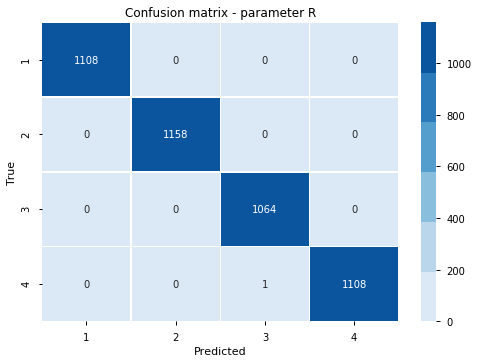

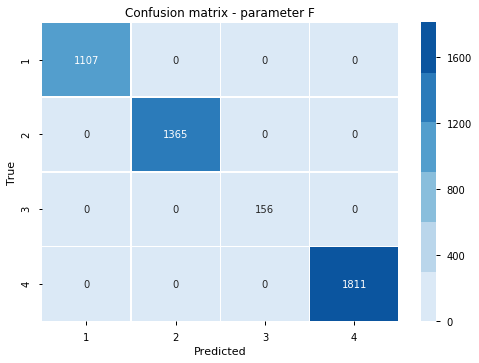

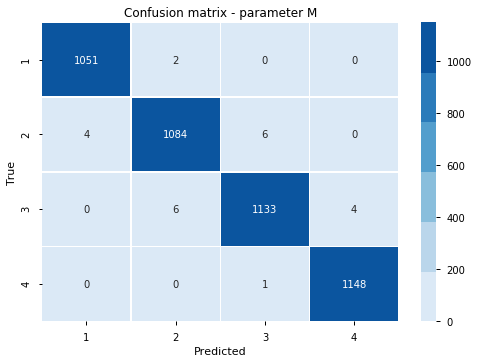

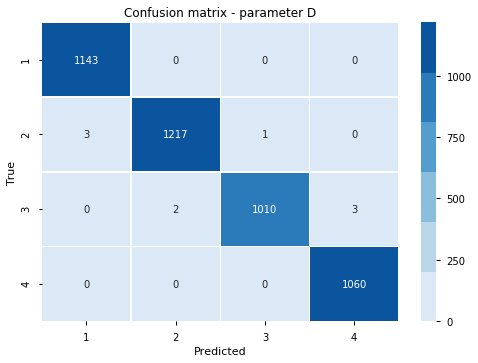

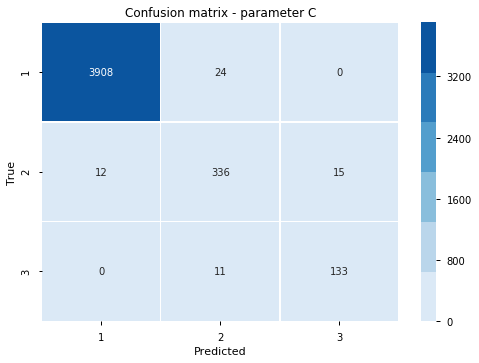

In [128]:
#Confusion matrix
labelsdict = {'R':[1,2,3,4], 'F':[1,2,3,4], 'M':[1,2,3,4], 'D':[1,2,3,4], 'C':[1,2,3]}
for parameter, classif in xgboostdict.items():
    labels = labelsdict[parameter]
    confmatrix = confusion_matrix(classif.predict(X_test_scaled), ytest[parameter], labels)
    ax = sns.heatmap(confmatrix, linewidths=.5, annot=True, fmt="d", cmap = sns.color_palette("Blues"))
    plt.title('Confusion matrix - parameter {}'.format(parameter))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()
    #print(confmatrix)

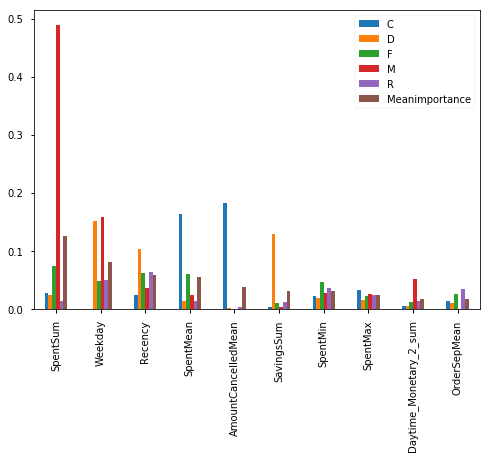

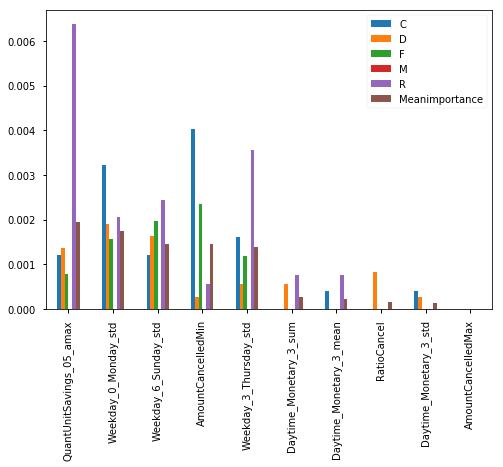

In [115]:
#Feature importance for all the features - XGBoost
featimpXGB = pd.DataFrame(data=featureimportancedictXGBoost, index = variables)
featimpXGB['Meanimportance'] = featimpXGB.apply(np.mean, axis = 1)
featimpXGB = featimpXGB.sort_values('Meanimportance', ascending = False)
featimpXGB[:10].plot(kind = 'bar')
plt.show()

featimpXGB[-10:].plot(kind = 'bar')
plt.show()

In [28]:
ytest.describe()

,R,F,M,D,C,RFMDC
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,2.450820,2.618852,2.590164,2.413934,1.122951,27411.327869
std,1.093207,1.291876,1.131328,1.113317,0.386562,11698.501067
min,1.000000,1.000000,1.000000,1.000000,1.000000,11111.000000
25%,2.000000,1.000000,2.000000,1.000000,1.000000,21118.500000
50%,2.000000,2.000000,3.000000,2.000000,1.000000,24421.000000
75%,3.000000,4.000000,4.000000,3.000000,1.000000,34431.000000
max,4.000000,4.000000,4.000000,4.000000,3.000000,44431.000000
